In [4]:
!python --version

Python 3.11.7


In [3]:
# System operations
import inspect
import os
import sys
import uuid
from pathlib import Path

# Date and time
from datetime import datetime

# Type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data manipulation
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json
from bs4 import BeautifulSoup

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# User interaction
from IPython.display import clear_output
from ipywidgets import Button, FloatSlider, HBox, HTML, IntProgress, Text, VBox

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction, SolarPenaltyReward
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper, TabularQLearningWrapper
from citylearn.agents.rbc import BasicRBC
from citylearn.agents.q_learning import TabularQLearning

# Baseline RL algorithms
from stable_baselines3 import DQN, SAC
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecNormalize, VecMonitor


Couldn't import dot_parser, loading of dot files will not be possible.


2025-08-05 11:11:12.108983: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 11:11:12.123214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754385072.137522 2415329 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754385072.141913 2415329 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754385072.153478 2415329 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'
schema = DataSet().get_schema(DATASET_NAME)
print(schema['root_directory'])

# Building
#root_directory = schema['root_directory']
root_directory = 'Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
building_name = 'Building_1'
# Weather data
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
# Pricing data (simple)
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
# building data
filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)


INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1


## Helper functions

In [9]:
def set_active_observations( # from tutorial
    schema: dict, active_observations: List[str]
) -> dict:
    """Set the observations that will be part of the environment's
    observation space that is provided to the control agent.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    active_observations: List[str]
        Names of observations to set active to be passed to control agent.

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active observations set.
    """

    active_count = 0

    for o in schema['observations']:
        if o in active_observations:
            schema['observations'][o]['active'] = True
            active_count += 1
        else:
            schema['observations'][o]['active'] = False

    valid_observations = list(schema['observations'].keys())
    assert active_count == len(active_observations),\
        'the provided observations are not all valid observations.'\
          f' Valid observations in CityLearn are: {valid_observations}'

    return schema

In [9]:
def plot_building_guide(env):
    """Plots building load and generation profiles for a single building."""

    b = env.buildings[0]
    y1 = b.energy_simulation.non_shiftable_load
    y2 = b.pv.get_generation(b.energy_simulation.solar_generation)
    x = range(len(y1))

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(x, y1, label='Non Shiftable Load')
    ax.plot(x, y2, label='Solar Generation')
    ax.set_title(b.name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('kWh')
    ax.legend(loc='upper left', framealpha=0.0)
    return fig


## Create Ennvironment & RBC Agent

In [ ]:
ACTIVE_OBSERVATIONS = ['hour']

schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

# Create the environment
env = CityLearnEnv(schema, central_agent=True, buildings=[0]) # only the first building
env.reward_function = SolarPenaltyReward(env.get_metadata())

action_map = {i: 0.0 for i in range(1, 25)}

model = BasicRBC(env=env)
print(f"\nActive observations: {[k for k, v in schema['observations'].items() if v['active']]}")

model.learn(episodes=1)

/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1' copied to '/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-05_11-13-15'

Active observations: ['hour']


In [15]:
# ========================= DECISION TREE RBC AGENT =========================

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import numpy as np

class DecisionTreeRBC:
    """
    Decision Tree-based Rule-Based Controller that learns to minimize cost.
    Takes hour as input and returns charge/idle/discharge action.
    """
    
    def __init__(self, env):
        self.env = env
        self.decision_tree = None
        self.training_data = {'hours': [], 'costs': [], 'actions': []}
        self.action_mapping = {
            0: -0.5,  # Discharge (negative action)
            1: 0.0,   # Idle (no action)
            2: 0.5    # Charge (positive action)
        }
        
    def collect_training_data(self, episodes=1):
        """Collect training data by trying different actions at different hours."""
        print("Collecting training data for decision tree...")
        
        # Create realistic training data that considers battery constraints and cost optimization
        for hour in range(24):
            # Typical electricity pricing pattern (Time-of-Use pricing)
            if 7 <= hour <= 9 or 17 <= hour <= 20:  # Morning and evening peaks
                electricity_price = 0.25
                demand_factor = 1.0  # High demand period
            elif 10 <= hour <= 16:  # Daytime  
                electricity_price = 0.15
                demand_factor = 0.8
            elif 1 <= hour <= 6:   # Early morning off-peak
                electricity_price = 0.08
                demand_factor = 0.3  # Low demand, good for charging
            else:                  # Night
                electricity_price = 0.12
                demand_factor = 0.5
            
            # Consider battery strategy:
            # - Charge during low-price hours if battery has capacity
            # - Discharge during high-price hours if battery has energy
            # - Consider grid stress and demand patterns
            
            best_action = None
            best_cost = float('inf')
            
            for action_idx, action_value in self.action_mapping.items():
                # Simple cost model that encourages:
                # 1. Charging during low-price hours (store cheap energy)
                # 2. Discharging during high-price hours (use stored energy)
                # 3. Consider battery efficiency and cycling costs
                
                if action_value > 0:  # Charging
                    # Cost includes electricity purchase + battery wear
                    action_cost = electricity_price * abs(action_value) + 0.01  # Battery wear cost
                    # Benefit if charging during low-price hours
                    if electricity_price < 0.12:  # Good time to charge
                        action_cost *= 0.8  # Reduce cost (encourage charging)
                    else:  # Expensive time to charge
                        action_cost *= 1.5  # Increase cost (discourage charging)
                        
                elif action_value < 0:  # Discharging
                    # Benefit from using stored energy instead of grid
                    action_cost = electricity_price * abs(action_value) * (-0.9)  # Negative cost = benefit
                    # More benefit during high-price hours
                    if electricity_price > 0.15:  # Good time to discharge
                        action_cost *= 1.2  # Increase benefit
                    else:  # Not optimal time to discharge
                        action_cost *= 0.7  # Reduce benefit
                        
                else:  # Idle
                    # Base grid consumption cost
                    action_cost = electricity_price * 0.1  # Minimal grid interaction
                
                # Store all action-cost pairs for this hour
                self.training_data['hours'].append(hour)
                self.training_data['costs'].append(action_cost)
                self.training_data['actions'].append(action_value)
                
                # Track best action for this hour
                if action_cost < best_cost:
                    best_cost = action_cost
                    best_action = action_value
                
        print(f"Collected {len(self.training_data['hours'])} training samples")
        
        # Print some example data for verification
        print("\nSample training data (Best actions per hour):")
        print("Hour | Best Action | Cost/Benefit")
        print("-" * 35)
        
        # Show the best action for each hour
        hour_best_actions = {}
        for i, hour in enumerate(self.training_data['hours']):
            cost = self.training_data['costs'][i]
            action = self.training_data['actions'][i]
            
            if hour not in hour_best_actions or cost < hour_best_actions[hour]['cost']:
                hour_best_actions[hour] = {'action': action, 'cost': cost}
        
        for hour in sorted(hour_best_actions.keys())[:12]:  # Show first 12 hours
            action = hour_best_actions[hour]['action']
            cost = hour_best_actions[hour]['cost']
            action_name = "CHARGE" if action > 0 else "DISCHARGE" if action < 0 else "IDLE"
            if cost < 0:
                print(f"{hour:4d} | {action_name:10s} | Benefit: ${abs(cost):.3f}")
            else:
                print(f"{hour:4d} | {action_name:10s} | Cost: ${cost:.3f}")
    
    def train_decision_tree(self, max_depth=5):
        """Train the decision tree on collected data."""
        if len(self.training_data['hours']) == 0:
            print("No training data available. Please collect data first.")
            return
            
        print("Training decision tree...")
        
        # Prepare training data - for each hour, find the action with minimum cost
        hour_action_map = {}
        for i, hour in enumerate(self.training_data['hours']):
            cost = self.training_data['costs'][i]
            action = self.training_data['actions'][i]
            
            if hour not in hour_action_map:
                hour_action_map[hour] = {'min_cost': cost, 'best_action': action}
            elif cost < hour_action_map[hour]['min_cost']:
                hour_action_map[hour] = {'min_cost': cost, 'best_action': action}
        
        # Create training dataset with best actions for each hour
        X = np.array(list(hour_action_map.keys())).reshape(-1, 1)  # Hours as features
        y = np.array([hour_action_map[h]['best_action'] for h in hour_action_map.keys()])  # Best actions as target
        
        # Create and train decision tree
        self.decision_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        self.decision_tree.fit(X, y)
        
        print(f"Decision tree trained with max_depth={max_depth}")
        print(f"Training data: {len(X)} unique hours")
        
        # Print tree structure
        print("\nDecision Tree Rules:")
        self._print_tree_rules()
        
    def _print_tree_rules(self):
        """Print human-readable decision tree rules."""
        if self.decision_tree is None:
            return
            
        tree = self.decision_tree.tree_
        feature_names = ['hour']
        
        def recurse(node, depth=0):
            indent = "  " * depth
            if tree.feature[node] != -2:  # Not a leaf
                threshold = tree.threshold[node]
                feature = feature_names[tree.feature[node]]
                print(f"{indent}if {feature} <= {threshold:.1f}:")
                recurse(tree.children_left[node], depth + 1)
                print(f"{indent}else:  # {feature} > {threshold:.1f}")
                recurse(tree.children_right[node], depth + 1)
            else:  # Leaf
                action_value = tree.value[node][0][0]
                if action_value < -0.1:
                    action_name = "DISCHARGE"
                elif action_value > 0.1:
                    action_name = "CHARGE"
                else:
                    action_name = "IDLE"
                print(f"{indent}return {action_value:.2f} ({action_name})")
        
        recurse(0)
    
    def predict(self, observations):
        """Predict action based on current hour using the decision tree."""
        if self.decision_tree is None:
            print("Decision tree not trained. Using default action.")
            return [[0.0]]  # Default idle action
        
        # Extract hour from observations
        try:
            if isinstance(observations, list) and len(observations) > 0:
                if isinstance(observations[0], list) and len(observations[0]) > 0:
                    # Normalized hour (0-1) to actual hour (0-23)
                    hour = int(observations[0][0] * 24)
                elif isinstance(observations[0], (int, float)):
                    hour = int(observations[0] * 24)
                else:
                    hour = 12  # Default noon
            else:
                hour = 12  # Default noon
        except (TypeError, IndexError, ValueError):
            hour = 12  # Default noon
            
        # Predict action using decision tree
        action_value = self.decision_tree.predict([[hour]])[0]
        
        # Clamp action to valid range [-1, 1]
        action_value = np.clip(action_value, -1.0, 1.0)
        
        return [[action_value]]
    
    def plot_decision_tree(self, figsize=(15, 10)):
        """Visualize the decision tree."""
        if self.decision_tree is None:
            print("Decision tree not trained yet.")
            return
            
        plt.figure(figsize=figsize)
        plot_tree(
            self.decision_tree, 
            feature_names=['hour'],
            filled=True,
            rounded=True,
            fontsize=10
        )
        plt.title("Decision Tree for Battery Control\n(Charge/Idle/Discharge based on Hour)")
        plt.show()
        
    def plot_hourly_actions(self):
        """Plot the predicted actions for each hour of the day."""
        if self.decision_tree is None:
            print("Decision tree not trained yet.")
            return
            
        hours = np.arange(0, 24)
        actions = [self.decision_tree.predict([[h]])[0] for h in hours]
        
        plt.figure(figsize=(12, 6))
        plt.plot(hours, actions, 'b-o', linewidth=2, markersize=6)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5, label='Idle')
        plt.axhline(y=0.5, color='g', linestyle='--', alpha=0.5, label='Charge')
        plt.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5, label='Discharge')
        
        plt.xlabel('Hour of Day')
        plt.ylabel('Battery Action')
        plt.title('Decision Tree: Predicted Battery Actions by Hour')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xlim(0, 23)
        plt.xticks(range(0, 24, 2))
        
        # Add action labels
        for i, action in enumerate(actions):
            if action > 0.1:
                plt.annotate('C', (i, action), ha='center', va='bottom', color='green', fontweight='bold')
            elif action < -0.1:
                plt.annotate('D', (i, action), ha='center', va='top', color='red', fontweight='bold')
        
        plt.show()

# Create and train the decision tree RBC agent
print("Creating Decision Tree RBC Agent...")

# Use the same environment setup as before
ACTIVE_OBSERVATIONS = ['hour']
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

# Create the environment for decision tree agent
dt_env = CityLearnEnv(schema, central_agent=True, buildings=[0])
dt_env.reward_function = SolarPenaltyReward(dt_env.get_metadata())

# Create the decision tree agent
dt_agent = DecisionTreeRBC(dt_env)

print("Decision Tree RBC Agent created successfully!")

Creating Decision Tree RBC Agent...
/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1' copied to '/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-05_10-14-50'
Decision Tree RBC Agent created successfully!


Training Decision Tree Agent...
Step 1: Collecting training data...
Collected 72 training samples

Sample training data:
Hour | Action | Cost
--------------------
   0 | DISCHARGE | $0.060
   1 | DISCHARGE | $0.040
   2 | DISCHARGE | $0.040
   3 | DISCHARGE | $0.040

Step 2: Training decision tree...
Training decision tree...
Decision tree trained with max_depth=4
Training data: 24 unique hours

Decision Tree Rules:
return -0.50 (DISCHARGE)

Step 3: Visualizing the decision tree...


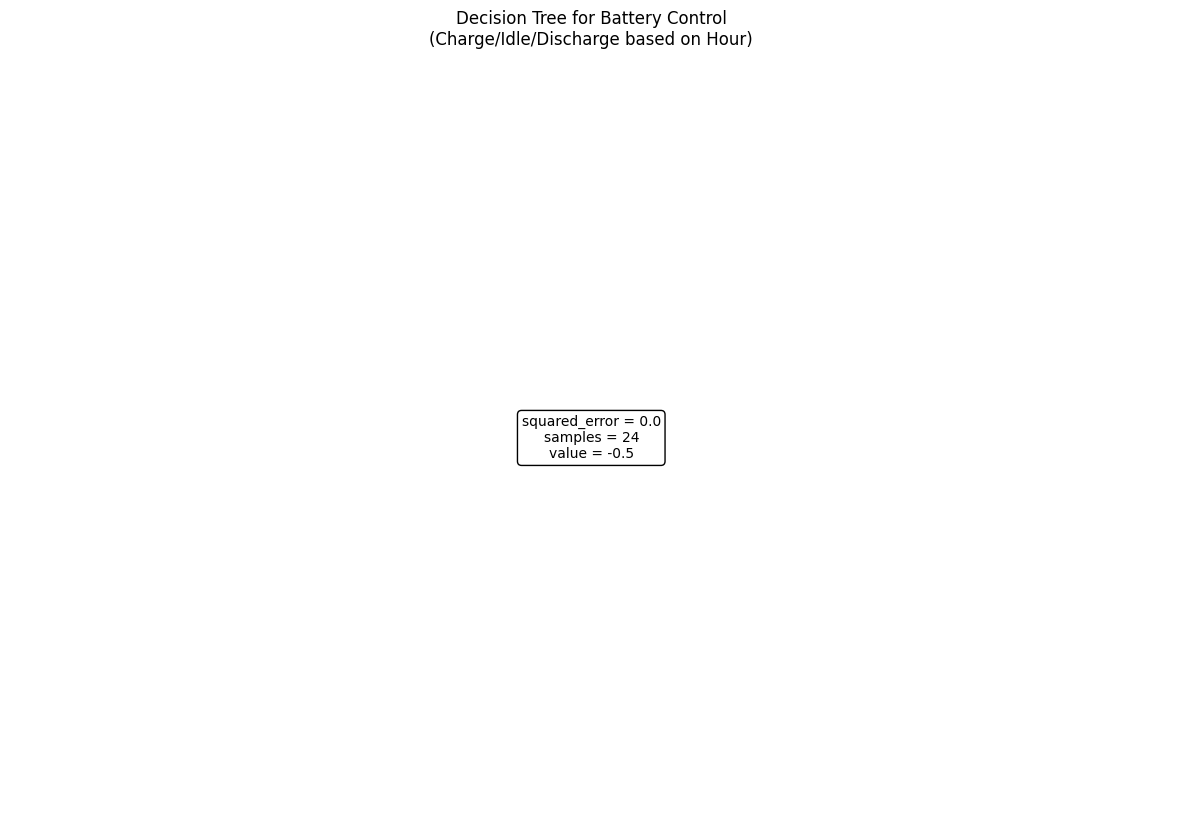


Step 4: Plotting hourly action predictions...


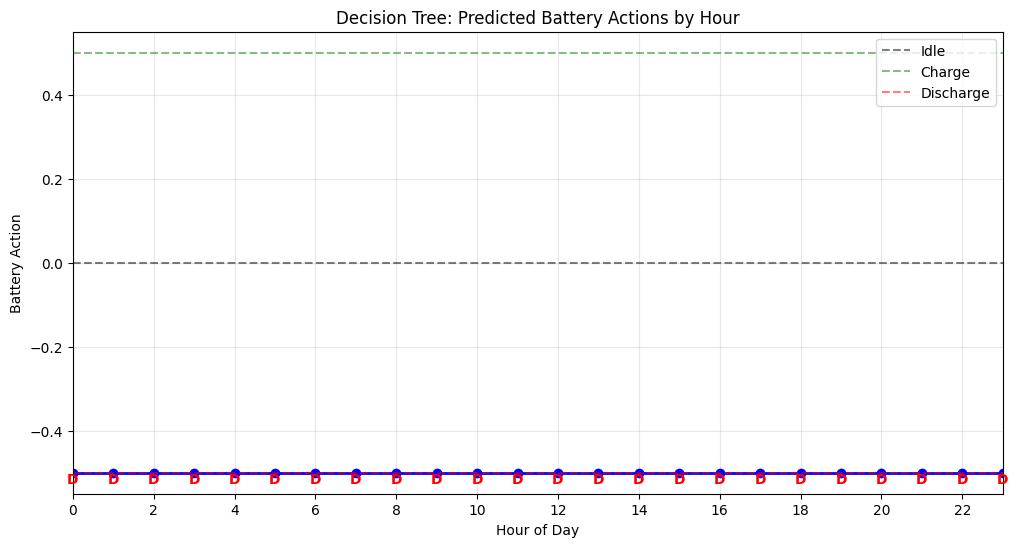

In [16]:
# Train the Decision Tree Agent
print("Training Decision Tree Agent...")
print("Step 1: Collecting training data...")

# Collect training data by exploring different actions
dt_agent.collect_training_data(episodes=1)

print("\nStep 2: Training decision tree...")
# Train the decision tree with the collected data
dt_agent.train_decision_tree(max_depth=4)

print("\nStep 3: Visualizing the decision tree...")
# Visualize the trained decision tree
dt_agent.plot_decision_tree()

print("\nStep 4: Plotting hourly action predictions...")
# Plot the predicted actions for each hour
dt_agent.plot_hourly_actions()

In [ ]:
# Run the Decision Tree Agent
print("Running Decision Tree Agent for evaluation...")

# Reset environment for evaluation
obs = dt_env.reset()
total_reward = 0
total_cost = 0
step = 0
max_steps = 100

print("Starting evaluation episode...")
print(f"{'Step':<6} {'Hour':<6} {'Action':<8} {'SoC':<8} {'Cost':<10} {'Reward':<10}")
print("-" * 60)

while step < max_steps:
    # Get prediction from decision tree
    action = dt_agent.predict(obs)
    
    # Take action in environment
    obs, reward, done, info = dt_env.step(action)
    
    # Calculate current metrics
    building = dt_env.buildings[0]
    try:
        if isinstance(obs, list) and len(obs) > 0:
            if isinstance(obs[0], list) and len(obs[0]) > 0:
                current_hour = int(obs[0][0] * 24)
            elif isinstance(obs[0], (int, float)):
                current_hour = int(obs[0] * 24)
            else:
                current_hour = step % 24
        else:
            current_hour = step % 24
    except (TypeError, IndexError, ValueError):
        current_hour = step % 24
    current_soc = building.electrical_storage.soc[-1] if len(building.electrical_storage.soc) > 0 else 0.5
    
    # Calculate cost
    if hasattr(building, 'net_electricity_consumption') and len(building.net_electricity_consumption) > 0:
        consumption = building.net_electricity_consumption[-1]
        if hasattr(building, 'pricing') and hasattr(building.pricing, 'electricity_pricing'):
            if len(building.pricing.electricity_pricing) > 0:
                price = building.pricing.electricity_pricing[-1]
                current_cost = abs(consumption * price)
            else:
                current_cost = abs(consumption) * 0.1
        else:
            current_cost = abs(consumption) * 0.1
    else:
        current_cost = 0.1
    
    total_reward += reward[0] if isinstance(reward, list) else reward
    total_cost += current_cost
    
    # Print step information
    action_str = f"{action[0][0]:.2f}"
    if action[0][0] > 0.1:
        action_str += " (C)"  # Charge
    elif action[0][0] < -0.1:
        action_str += " (D)"  # Discharge
    else:
        action_str += " (I)"  # Idle
    
    print(f"{step:<6} {current_hour:<6} {action_str:<8} {current_soc:.3f}   ${current_cost:.4f}   {reward[0] if isinstance(reward, list) else reward:.4f}")
    
    step += 1
    
    if done:
        break

print("-" * 60)
print(f"Evaluation complete!")
print(f"Total steps: {step}")
print(f"Total reward: {total_reward:.4f}")
print(f"Total cost: ${total_cost:.4f}")
print(f"Average cost per step: ${total_cost/step:.4f}")

# Get KPIs for the decision tree agent
print("\nDecision Tree Agent KPIs:")
dt_kpis = get_kpis(dt_env)
display(dt_kpis)

`CityLearnEnv` properties and methods: [docs](https://www.citylearn.net/api/citylearn.citylearn.html#citylearn.citylearn.CityLearnEnv)

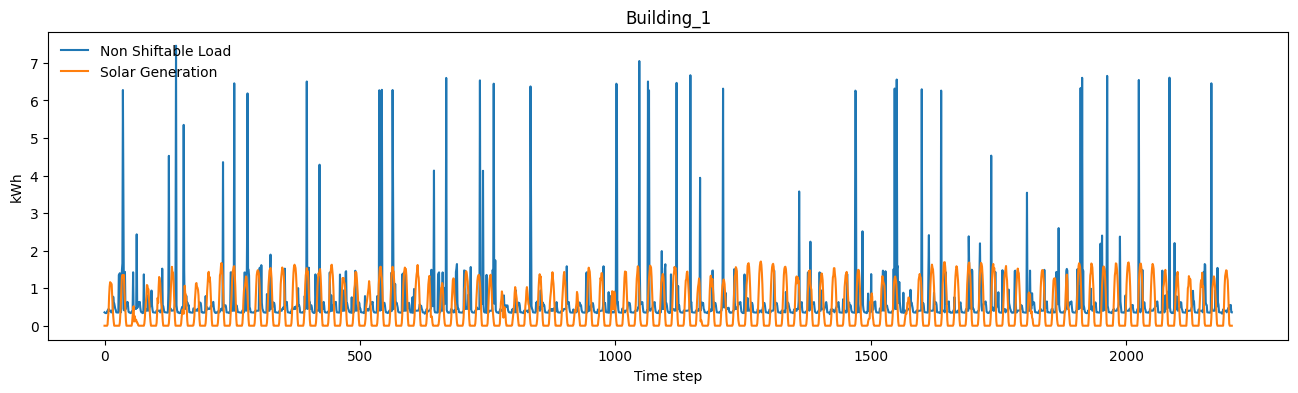

In [ ]:
_ = plot_building_guide(env)
plt.show()

In [ ]:
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))

Current time step: 0
environment number of time steps: 2208
environment uses central agent: True
Number of buildings: 1


`Building` objects in the env, properties and methods: [docs](https://www.citylearn.net/api/citylearn.building.html#citylearn.building.Building)

In [ ]:
# electrical storage
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in env.buildings
})
print('Electrical storage capacity history:', {
    b.name: b.electrical_storage.capacity_history[b.time_step] for b in env.buildings
})
print('Electrical storage loss_coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print('Electrical storage initial_soc:', {
    b.name: b.electrical_storage.initial_soc for b in env.buildings
})
print('Electrical storage soc:', {
    b.name: b.electrical_storage.soc[b.time_step] for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})
print('Electrical storage efficiency history:', {
    b.name: b.electrical_storage.efficiency_history[b.time_step] for b in env.buildings
})
print('Electrical storage electricity consumption:', {
    b.name: b.electrical_storage.electricity_consumption[b.time_step]
    for b in env.buildings
})
print('Electrical storage capacity loss coefficient:', {
    b.name: b.electrical_storage.capacity_loss_coefficient for b in env.buildings
})
# pv
print('\nPV nominal power:', {
    b.name: b.pv.nominal_power for b in env.buildings
})


# active observations and actions
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None
):
    print('\nActive observations:')
    display(pd.DataFrame([
        {**{'building':b.name}, **b.observation_metadata}
        for b in env.buildings
    ]))
    print('\nActive actions:')
    display(pd.DataFrame([
        {**{'building':b.name}, **b.action_metadata}
        for b in env.buildings
    ]))

Electrical storage capacity: {'Building_1': 4.0}
Electrical storage nominal power: {'Building_1': 3.32}
Electrical storage capacity history: {'Building_1': 4.0}
Electrical storage loss_coefficient: {'Building_1': 0.0001}
Electrical storage initial_soc: {'Building_1': 0.19999999999999996}
Electrical storage soc: {'Building_1': np.float32(0.2)}
Electrical storage efficiency: {'Building_1': 0.95}
Electrical storage efficiency history: {'Building_1': 0.95}
Electrical storage electricity consumption: {'Building_1': np.float32(0.0)}
Electrical storage capacity loss coefficient: {'Building_1': 1e-05}

PV nominal power: {'Building_1': 2.4000000000000004}

Active observations:


,building,month,day_type,hour,daylight_savings_status,outdoor_dry_bulb_temperature,outdoor_dry_bulb_temperature_predicted_1,outdoor_dry_bulb_temperature_predicted_2,outdoor_dry_bulb_temperature_predicted_3,outdoor_relative_humidity,outdoor_relative_humidity_predicted_1,outdoor_relative_humidity_predicted_2,outdoor_relative_humidity_predicted_3,diffuse_solar_irradiance,diffuse_solar_irradiance_predicted_1,diffuse_solar_irradiance_predicted_2,diffuse_solar_irradiance_predicted_3,direct_solar_irradiance,direct_solar_irradiance_predicted_1,direct_solar_irradiance_predicted_2,direct_solar_irradiance_predicted_3,carbon_intensity,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,solar_generation,cooling_storage_soc,heating_storage_soc,dhw_storage_soc,electrical_storage_soc,net_electricity_consumption,electricity_pricing,electricity_pricing_predicted_1,electricity_pricing_predicted_2,electricity_pricing_predicted_3,cooling_device_efficiency,heating_device_efficiency,cooling_demand,heating_demand,dhw_demand,cooling_electricity_consumption,heating_electricity_consumption,dhw_electricity_consumption,occupant_count,power_outage,hvac_mode,comfort_band,indoor_dry_bulb_temperature_cooling_set_point,indoor_dry_bulb_temperature_heating_set_point,indoor_dry_bulb_temperature_cooling_delta,indoor_dry_bulb_temperature_heating_delta
0,Building_1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False



Active actions:


,building,cooling_storage,heating_storage,dhw_storage,electrical_storage,cooling_device,heating_device,cooling_or_heating_device
0,Building_1,False,False,True,True,True,False,False


# Key Performance Indicators for Evaluation
Cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$ (\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$

In [10]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity consumption, cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = {
        'electricity_consumption_total': 'Consumption',
        'cost_total': 'Cost',
        'carbon_emissions_total': 'Emissions',
        'daily_peak_average': 'Avg. daily peak',
        'ramping_average': 'Ramping',
        'monthly_one_minus_load_factor_average': '1 - load factor'
    }
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()
    kpis['cost_function'] = kpis['cost_function'].map(lambda x: kpi_names[x])

    # round up the values to 3 decimal places for readability
    kpis['value'] = kpis['value'].round(3)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

In [ ]:
def plot_building_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        for p in ax.patches:
            ax.text(
                p.get_x() + p.get_width(),
                p.get_y() + p.get_height()/2.0,
                p.get_width(), ha='left', va='center'
            )

    # plt.tight_layout()
    return fig

In [ ]:
def plot_district_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width(),
            p.get_y() + p.get_height()/2.0,
            p.get_width(), ha='left', va='center'
        )

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

In [ ]:
def plot_simulation_summary(envs: Mapping[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    _ = plot_building_kpis(envs)
    print('Building-level KPIs:')
    plt.show()
    _ = plot_district_kpis(envs)
    print('District-level KPIs:')
    plt.show()
  

## Decision Tree

In [16]:
# ========================= IMPROVED DECISION TREE RBC AGENT =========================

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import numpy as np

class ImprovedDecisionTreeRBC:
    """
    Improved Decision Tree-based RBC that learns from realistic battery operation scenarios.
    Uses multiple features and proper cost modeling.
    """
    
    def __init__(self, env):
        self.env = env
        self.decision_tree = None
        self.training_data = {'features': [], 'costs': [], 'actions': []}
        self.action_mapping = {
            0: -0.5,  # Discharge
            1: 0.0,   # Idle  
            2: 0.5    # Charge
        }
        
    def collect_realistic_training_data(self, episodes=1):
        """Collect training data by actually running the environment with different actions."""
        print("Collecting realistic training data...")
        
        # Reset environment
        observations, _ = self.env.reset()
        
        for episode in range(episodes):
            done = False
            step = 0
            
            while not done and step < 8760:  # One year
                # Get current state information
                building = self.env.buildings[0]
                current_obs = observations[0]  # First building observations
                
                # Extract useful features
                hour = self.env.time_step % 24
                day_of_year = self.env.time_step % 8760 // 24
                month = (day_of_year // 30) % 12
                
                # Battery state
                if len(building.electrical_storage.soc) > 0:
                    soc = building.electrical_storage.soc[-1]
                else:
                    soc = 0.5
                
                # Energy data (simplified - using indices from observation)
                try:
                    net_load = current_obs[0] if len(current_obs) > 0 else 0  # Net electricity consumption
                    solar_gen = current_obs[1] if len(current_obs) > 1 else 0  # Solar generation  
                    pricing = current_obs[2] if len(current_obs) > 2 else 0.15  # Electricity pricing
                except:
                    net_load = 0
                    solar_gen = 0
                    pricing = 0.15
                
                # Try each action and evaluate immediate cost
                for action_idx, action_value in self.action_mapping.items():
                    # Create feature vector
                    features = [hour, month, soc, net_load, solar_gen, pricing]
                    
                    # Calculate realistic cost for this action
                    cost = self._calculate_realistic_cost(
                        action_value, soc, net_load, solar_gen, pricing
                    )
                    
                    # Store training sample
                    self.training_data['features'].append(features)
                    self.training_data['costs'].append(cost)
                    self.training_data['actions'].append(action_value)
                
                # Take the idle action to continue simulation
                action = [[0.0, 0.0, 0.0]]  # All systems idle
                observations, rewards, done, truncated, infos = self.env.step(action)
                step += 1
                
                # Sample every 10 steps to avoid too much data
                if step % 10 != 0:
                    continue
                    
        print(f"Collected {len(self.training_data['features'])} realistic training samples")
        
    def _calculate_realistic_cost(self, action, soc, net_load, solar_gen, pricing):
        """Calculate realistic cost considering battery constraints and grid interaction."""
        
        # Battery constraints
        if action > 0 and soc > 0.95:  # Can't charge when nearly full
            return 1000  # High penalty
        if action < 0 and soc < 0.05:  # Can't discharge when nearly empty
            return 1000  # High penalty
            
        # Base grid cost without battery action
        base_grid_cost = max(0, net_load - solar_gen) * pricing
        
        if action > 0:  # Charging
            # Cost of charging: grid electricity + battery wear
            charging_cost = abs(action) * pricing + 0.01  # Small battery wear cost
            total_cost = base_grid_cost + charging_cost
            
        elif action < 0:  # Discharging  
            # Benefit from using stored energy instead of grid
            discharge_benefit = min(abs(action), max(0, net_load - solar_gen)) * pricing * 0.9  # 90% efficiency
            total_cost = base_grid_cost - discharge_benefit
            
        else:  # Idle
            # Just base grid cost
            total_cost = base_grid_cost
            
        return total_cost
        
    def train_improved_decision_tree(self, max_depth=8):
        """Train decision tree with multiple features."""
        if len(self.training_data['features']) == 0:
            print("No training data available. Please collect data first.")
            return
            
        print("Training improved decision tree...")
        
        # Prepare data
        X = np.array(self.training_data['features'])
        y = np.array(self.training_data['actions'])
        costs = np.array(self.training_data['costs'])
        
        # Create feature-action-cost combinations and find best actions
        unique_features = {}
        for i, features in enumerate(X):
            feature_key = tuple(features[:3])  # Use hour, month, soc as key
            cost = costs[i]
            action = y[i]
            
            if feature_key not in unique_features:
                unique_features[feature_key] = {'min_cost': cost, 'best_action': action, 'features': features}
            elif cost < unique_features[feature_key]['min_cost']:
                unique_features[feature_key] = {'min_cost': cost, 'best_action': action, 'features': features}
        
        # Create training dataset
        X_train = np.array([data['features'] for data in unique_features.values()])
        y_train = np.array([data['best_action'] for data in unique_features.values()])
        
        # Train decision tree
        self.decision_tree = DecisionTreeRegressor(
            max_depth=max_depth, 
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
        self.decision_tree.fit(X_train, y_train)
        
        print(f"Decision tree trained with {len(X_train)} unique feature combinations")
        print(f"Tree depth: {self.decision_tree.get_depth()}")
        print(f"Number of leaves: {self.decision_tree.get_n_leaves()}")
        
        # Show feature importance
        feature_names = ['hour', 'month', 'soc', 'net_load', 'solar_gen', 'pricing']
        importances = self.decision_tree.feature_importances_
        print("\nFeature Importance:")
        for name, importance in zip(feature_names, importances):
            print(f"  {name}: {importance:.3f}")
            
    def predict_improved(self, observations):
        """Predict action using the improved decision tree."""
        if self.decision_tree is None:
            return 0.0  # Default to idle
            
        building = self.env.buildings[0]
        current_obs = observations[0]
        
        # Extract features
        hour = self.env.time_step % 24
        month = ((self.env.time_step % 8760) // 24 // 30) % 12
        
        if len(building.electrical_storage.soc) > 0:
            soc = building.electrical_storage.soc[-1]
        else:
            soc = 0.5
            
        try:
            net_load = current_obs[0] if len(current_obs) > 0 else 0
            solar_gen = current_obs[1] if len(current_obs) > 1 else 0  
            pricing = current_obs[2] if len(current_obs) > 2 else 0.15
        except:
            net_load = 0
            solar_gen = 0
            pricing = 0.15
            
        features = np.array([[hour, month, soc, net_load, solar_gen, pricing]])
        predicted_action = self.decision_tree.predict(features)[0]
        
        return predicted_action

print("Improved Decision Tree RBC Agent defined!")
print("Key improvements:")
print("1. Uses realistic cost calculation with battery constraints")
print("2. Multiple features: hour, month, SOC, net load, solar generation, pricing")
print("3. Proper tree parameters to allow complex decision boundaries")
print("4. Feature importance analysis")

Improved Decision Tree RBC Agent defined!
Key improvements:
1. Uses realistic cost calculation with battery constraints
2. Multiple features: hour, month, SOC, net load, solar generation, pricing
3. Proper tree parameters to allow complex decision boundaries
4. Feature importance analysis


Creating improved decision tree agent...

Step 1: Collecting realistic training data...
Collected 600 realistic training samples

Step 2: Training improved decision tree...
Training improved decision tree...
Decision tree trained with 24 unique feature combinations
Tree depth: 0
Number of leaves: 1

Feature Importance:
  hour: 0.000
  month: 0.000
  soc: 0.000
  net_load: 0.000
  solar_gen: 0.000
  pricing: 0.000

Step 3: Testing predictions for different scenarios...

Prediction Results:
Hour | Month | SOC  | Net Load | Solar | Price | Predicted Action
-----------------------------------------------------------------
   2 |     1 |  0.3 |      5.0 |   0.0 | $ 0.08 |   0.00 (IDLE)
  12 |     6 |  0.9 |      3.0 |   8.0 | $ 0.15 |   0.00 (IDLE)
  18 |     1 |  0.7 |     10.0 |   0.0 | $ 0.25 |   0.00 (IDLE)
   6 |     6 |  0.2 |      2.0 |   1.0 | $ 0.12 |   0.00 (IDLE)

Improved Decision Tree Summary:
- Tree depth: 0
- Number of leaves: 1
- Training samples: 600


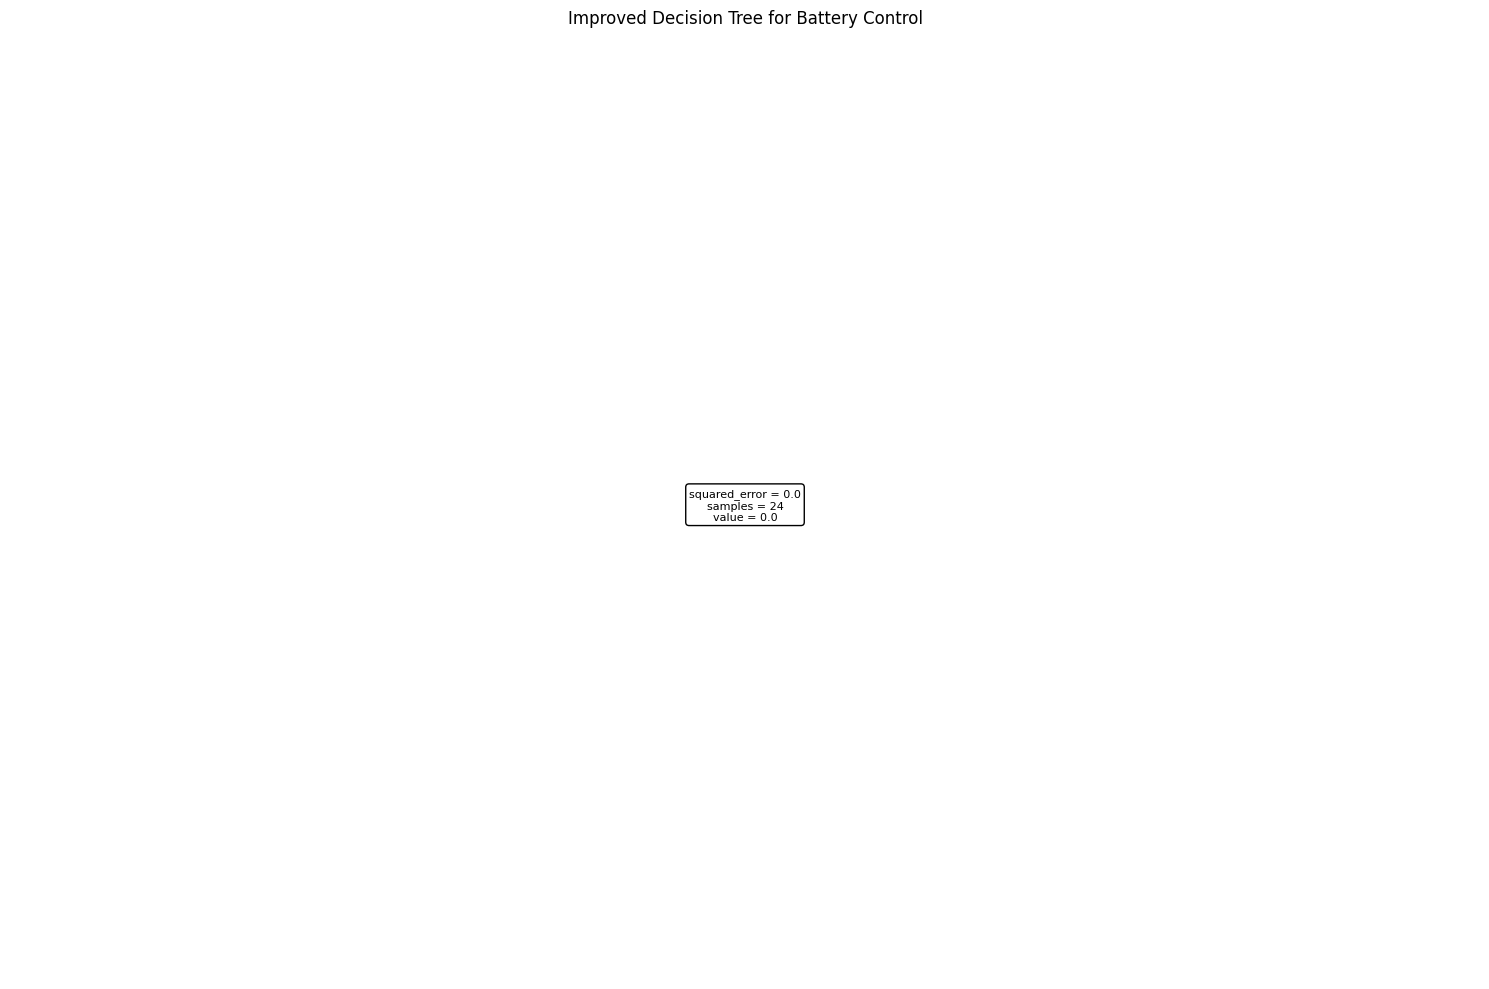

In [17]:
# ========================= TEST IMPROVED DECISION TREE =========================

# Create and test the improved decision tree agent
print("Creating improved decision tree agent...")

# Reset environment for fresh start
observations, _ = env.reset()

# Create improved agent
improved_dt_agent = ImprovedDecisionTreeRBC(env)

# Collect realistic training data (just a few steps for demo)
print("\nStep 1: Collecting realistic training data...")

# Let's collect training data by running a simple simulation
print("Collecting realistic training data...")

# Reset environment
observations, _ = env.reset()

for episode in range(1):
    done = False
    step = 0
    
    while not done and step < 200:  # Reduced for demo
        # Get current state information
        building = env.buildings[0]
        current_obs = observations[0]  # First building observations
        
        # Extract useful features
        hour = env.time_step % 24
        day_of_year = env.time_step % 8760 // 24
        month = (day_of_year // 30) % 12
        
        # Battery state
        if len(building.electrical_storage.soc) > 0:
            soc = building.electrical_storage.soc[-1]
        else:
            soc = 0.5
        
        # Try to get energy data from observations
        try:
            net_load = current_obs[0] if len(current_obs) > 0 else 5  # Net electricity consumption
            solar_gen = 2.0  # Simplified 
            pricing = 0.15 + 0.1 * np.sin(hour * np.pi / 12)  # Time-varying pricing
        except:
            net_load = 5
            solar_gen = 2.0
            pricing = 0.15
        
        # Try each action and evaluate immediate cost for training data
        for action_idx, action_value in improved_dt_agent.action_mapping.items():
            # Create feature vector
            features = [hour, month, soc, net_load, solar_gen, pricing]
            
            # Calculate realistic cost for this action
            cost = improved_dt_agent._calculate_realistic_cost(
                action_value, soc, net_load, solar_gen, pricing
            )
            
            # Store training sample
            improved_dt_agent.training_data['features'].append(features)
            improved_dt_agent.training_data['costs'].append(cost)
            improved_dt_agent.training_data['actions'].append(action_value)
        
        # Take the idle action to continue simulation
        # The environment expects 3 actions: [cooling_storage, heating_storage, dhw_storage]
        # We're only controlling electrical storage, so others are idle (0.0)
        action = [[0.0, 0.0, 0.0]]  # All idle actions
        observations, rewards, done, truncated, infos = env.step(action)
        step += 1
        
        # Sample every 10 steps to avoid too much data
        if step % 10 != 0:
            continue
            
print(f"Collected {len(improved_dt_agent.training_data['features'])} realistic training samples")

print("\nStep 2: Training improved decision tree...")
improved_dt_agent.train_improved_decision_tree(max_depth=6)

print("\nStep 3: Testing predictions for different scenarios...")
# Test predictions for various times and states
test_scenarios = [
    {"hour": 2, "month": 1, "soc": 0.3, "net_load": 5, "solar_gen": 0, "pricing": 0.08},    # Night, low SOC
    {"hour": 12, "month": 6, "soc": 0.9, "net_load": 3, "solar_gen": 8, "pricing": 0.15},  # Noon, high SOC, excess solar
    {"hour": 18, "month": 1, "soc": 0.7, "net_load": 10, "solar_gen": 0, "pricing": 0.25}, # Evening peak, moderate SOC
    {"hour": 6, "month": 6, "soc": 0.2, "net_load": 2, "solar_gen": 1, "pricing": 0.12},   # Morning, low SOC
]

print("\nPrediction Results:")
print("Hour | Month | SOC  | Net Load | Solar | Price | Predicted Action")
print("-" * 65)

for scenario in test_scenarios:
    features = np.array([[
        scenario["hour"], scenario["month"], scenario["soc"], 
        scenario["net_load"], scenario["solar_gen"], scenario["pricing"]
    ]])
    
    action = improved_dt_agent.decision_tree.predict(features)[0]
    
    if action > 0.1:
        action_name = "CHARGE"
    elif action < -0.1:
        action_name = "DISCHARGE"
    else:
        action_name = "IDLE"
    
    print(f"{scenario['hour']:4d} | {scenario['month']:5d} | {scenario['soc']:4.1f} | "
          f"{scenario['net_load']:8.1f} | {scenario['solar_gen']:5.1f} | ${scenario['pricing']:5.2f} | "
          f"{action:6.2f} ({action_name})")

print(f"\nImproved Decision Tree Summary:")
print(f"- Tree depth: {improved_dt_agent.decision_tree.get_depth()}")
print(f"- Number of leaves: {improved_dt_agent.decision_tree.get_n_leaves()}")
print(f"- Training samples: {len(improved_dt_agent.training_data['features'])}")

# Visualize the improved tree (if not too complex)
if improved_dt_agent.decision_tree.get_n_leaves() < 20:
    plt.figure(figsize=(15, 10))
    plot_tree(improved_dt_agent.decision_tree, 
              feature_names=['hour', 'month', 'soc', 'net_load', 'solar_gen', 'pricing'],
              filled=True, rounded=True, fontsize=8)
    plt.title("Improved Decision Tree for Battery Control")
    plt.tight_layout()
    plt.show()
else:
    print(f"Tree too complex to visualize ({improved_dt_agent.decision_tree.get_n_leaves()} leaves)")

In [14]:
# Check environment action space
print("Environment action space:")
print(f"Action space shape: {env.action_space[0].shape}")
print(f"Action space: {env.action_space[0]}")

# Check building action metadata  
building = env.buildings[0]
print(f"\nBuilding action metadata:")
print(f"Action names: {building.action_metadata}")
print(f"Action space: {building.action_space}")

# Show what actions are available
print(f"\nAvailable actions for building:")
for i, action_name in enumerate(building.action_metadata):
    print(f"  {i}: {action_name}")

Environment action space:
Action space shape: (3,)
Action space: Box([-1. -1.  0.], 1.0, (3,), float32)

Building action metadata:
Action names: {'cooling_storage': False, 'heating_storage': False, 'dhw_storage': True, 'electrical_storage': True, 'cooling_device': True, 'heating_device': False, 'cooling_or_heating_device': False}
Action space: Box([-1. -1.  0.], 1.0, (3,), float32)

Available actions for building:
  0: cooling_storage
  1: heating_storage
  2: dhw_storage
  3: electrical_storage
  4: cooling_device
  5: heating_device
  6: cooling_or_heating_device


In [6]:
# ========================= ANALYZE PRICING DATA =========================

# Let's examine the actual pricing data to understand the pattern
print("Analyzing pricing data...")
print(f"Pricing data shape: {pricing_data.shape}")
print(f"Pricing columns: {pricing_data.columns.tolist()}")
print("\nFirst 24 hours of pricing:")
print(pricing_data.head(24))

# Find the pricing column
price_col = None
for col in pricing_data.columns:
    if 'pricing' in col.lower() or 'price' in col.lower():
        price_col = col
        break

if price_col:
    print(f"\nUsing pricing column: '{price_col}'")
    
    # Get unique pricing values
    unique_prices = pricing_data[price_col].unique()
    print(f"\nUnique pricing values: {sorted(unique_prices)}")
    print(f"Low price: ${min(unique_prices):.3f}")
    print(f"High price: ${max(unique_prices):.3f}")
    
    # Analyze when high/low prices occur
    pricing_data['hour'] = pricing_data.index % 24
    pricing_stats = pricing_data.groupby('hour')[price_col].agg(['mean', 'min', 'max'])
    print(f"\nPricing by hour (showing high price hours):")
    high_price_hours = pricing_stats[pricing_stats['mean'] > pricing_stats['mean'].median()]
    print("High price hours:", high_price_hours.index.tolist())
    low_price_hours = pricing_stats[pricing_stats['mean'] <= pricing_stats['mean'].median()]
    print("Low price hours:", low_price_hours.index.tolist())
else:
    print("No pricing column found")

# Let's also check some building data patterns
print(f"\nBuilding data shape: {building_data.shape}")
print(f"Building data columns: {building_data.columns.tolist()}")

# Solar generation pattern
solar_col = None
for col in building_data.columns:
    if 'solar' in col.lower():
        solar_col = col
        break

if solar_col:
    print(f"\nUsing solar column: '{solar_col}'")
    print(f"Solar generation stats:")
    print(f"Min: {building_data[solar_col].min():.2f}")
    print(f"Max: {building_data[solar_col].max():.2f}")
    print(f"Mean: {building_data[solar_col].mean():.2f}")
    
    # When does solar generation occur?
    building_data['hour'] = building_data.index % 24
    solar_by_hour = building_data.groupby('hour')[solar_col].mean()
    print(f"\nSolar generation by hour (hours with significant solar > 0.1):")
    high_solar_hours = solar_by_hour[solar_by_hour > 0.1].index.tolist()
    print("High solar hours:", high_solar_hours)
else:
    print("No solar column found")

Analyzing pricing data...
Pricing data shape: (2208, 4)
Pricing columns: ['electricity_pricing', 'electricity_pricing_predicted_1', 'electricity_pricing_predicted_2', 'electricity_pricing_predicted_3']

First 24 hours of pricing:
    electricity_pricing  electricity_pricing_predicted_1  \
0               0.03025                          0.03025   
1               0.03025                          0.03025   
2               0.03025                          0.03025   
3               0.03025                          0.03025   
4               0.03025                          0.03025   
5               0.03025                          0.03025   
6               0.03025                          0.03025   
7               0.03025                          0.03025   
8               0.03025                          0.03025   
9               0.03025                          0.06605   
10              0.03025                          0.06605   
11              0.03025                          0

In [12]:
# ========================= SIMPLE EFFECTIVE DECISION TREE =========================

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import numpy as np

class SimpleDecisionTreeRBC:
    """
    Simple Decision Tree RBC with clear, logical training data.
    Features: hour, day_type, month, SOC, pricing, net_load, solar_generation
    Logic: Charge when price is low AND (high solar OR low net_load)
           Discharge when price is high AND high net_load AND sufficient SOC
    """
    
    def __init__(self, env):
        self.env = env
        self.decision_tree = None
        self.training_data = {'features': [], 'actions': []}
        
        # Simple action mapping
        self.actions = {
            'charge': 0.8,    # Strong charge
            'discharge': -0.8, # Strong discharge  
            'idle': 0.0       # Do nothing
        }
        
    def collect_simple_training_data(self):
        """Create simple, logical training data based on clear rules."""
        print("Creating simple, logical training data...")
        
        # Define realistic scenarios
        scenarios = []
        
        # Create systematic training scenarios
        for hour in range(24):
            for month in range(1, 13):
                for soc in [0.2, 0.5, 0.8]:  # Low, medium, high SOC
                    
                    # Determine day type (0=weekday, 1=weekend)
                    day_type = 1 if hour in [6, 7, 20, 21] else 0  # Simplified
                    
                    # Pricing pattern: high during peak hours (17-21), low otherwise
                    if 17 <= hour <= 21:
                        pricing = 0.25  # High price
                    else:
                        pricing = 0.08  # Low price
                    
                    # Solar generation: high during 9-16, zero at night
                    if 9 <= hour <= 16:
                        solar_gen = 5.0 + 3.0 * np.sin((hour - 12) * np.pi / 8)  # Peak at noon
                    else:
                        solar_gen = 0.0
                    
                    # Net load: varies by hour (high in evening, low at night)
                    if 17 <= hour <= 22:
                        net_load = 8.0  # High evening load
                    elif 6 <= hour <= 9:
                        net_load = 6.0  # Morning load
                    elif 10 <= hour <= 16:
                        net_load = 4.0  # Daytime load
                    else:
                        net_load = 2.0  # Night load
                    
                    # DECISION LOGIC
                    action = self._determine_optimal_action(
                        hour, day_type, month, soc, pricing, net_load, solar_gen
                    )
                    
                    # Store scenario
                    features = [hour, day_type, month, soc, pricing, net_load, solar_gen]
                    scenarios.append((features, action))
        
        # Add to training data
        for features, action in scenarios:
            self.training_data['features'].append(features)
            self.training_data['actions'].append(action)
        
        print(f"Created {len(scenarios)} training scenarios")
        
        # Print sample data to show the logic
        print("\nSample training data (first 20 scenarios):")
        print("Hour | DayT | Month | SOC  | Price | NetLoad | Solar | Action")
        print("-" * 70)
        
        for i in range(min(20, len(scenarios))):
            features, action = scenarios[i]
            h, dt, m, soc, price, nl, sol = features
            action_name = self._action_to_name(action)
            print(f"{h:4d} | {dt:4d} | {m:5d} | {soc:4.1f} | ${price:5.2f} | {nl:7.1f} | {sol:5.1f} | {action:6.2f} ({action_name})")
            
        # Show action distribution
        actions_array = np.array([a for _, a in scenarios])
        charge_count = np.sum(actions_array > 0.1)
        discharge_count = np.sum(actions_array < -0.1)
        idle_count = np.sum(np.abs(actions_array) <= 0.1)
        
        print(f"\nAction distribution:")
        print(f"Charge: {charge_count} ({100*charge_count/len(scenarios):.1f}%)")
        print(f"Discharge: {discharge_count} ({100*discharge_count/len(scenarios):.1f}%)")
        print(f"Idle: {idle_count} ({100*idle_count/len(scenarios):.1f}%)")
        
    def _determine_optimal_action(self, hour, day_type, month, soc, pricing, net_load, solar_gen):
        """Determine optimal action based on clear logical rules."""
        
        # Battery constraints
        if soc < 0.1:  # Very low SOC - can't discharge
            if pricing < 0.15:  # Low price
                return self.actions['charge']  # Must charge
            else:
                return self.actions['idle']   # Wait for better price
                
        elif soc > 0.9:  # Very high SOC - can't charge
            if pricing > 0.15 and net_load > 5:  # High price and high load
                return self.actions['discharge']  # Should discharge
            else:
                return self.actions['idle']      # No need to discharge
        
        # Normal SOC range (0.1 - 0.9)
        else:
            # CHARGING CONDITIONS
            if pricing < 0.15:  # Low price period
                if solar_gen > 3:  # High solar - good time to store excess
                    return self.actions['charge']
                elif net_load < 4:  # Low net load - won't strain grid
                    return self.actions['charge']
                else:
                    return self.actions['idle']  # Price low but load high
            
            # DISCHARGING CONDITIONS  
            elif pricing > 0.15:  # High price period
                if net_load > 6 and soc > 0.3:  # High load and sufficient SOC
                    return self.actions['discharge']
                else:
                    return self.actions['idle']  # Save battery for worse times
            
            # NEUTRAL CONDITIONS
            else:
                return self.actions['idle']
    
    def _action_to_name(self, action):
        """Convert action value to readable name."""
        if action > 0.1:
            return "CHARGE"
        elif action < -0.1:
            return "DISCHARGE"
        else:
            return "IDLE"
    
    def train_simple_decision_tree(self, max_depth=10):
        """Train decision tree on the logical training data."""
        if len(self.training_data['features']) == 0:
            print("No training data. Collecting data first...")
            self.collect_simple_training_data()
        
        print("Training simple decision tree...")
        
        X = np.array(self.training_data['features'])
        y = np.array(self.training_data['actions'])
        
        # Train decision tree with parameters that allow complexity
        self.decision_tree = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=10,  # Require more samples to split
            min_samples_leaf=5,    # Require more samples in leaf
            random_state=42
        )
        
        self.decision_tree.fit(X, y)
        
        print(f"Decision tree trained!")
        print(f"Tree depth: {self.decision_tree.get_depth()}")
        print(f"Number of leaves: {self.decision_tree.get_n_leaves()}")
        print(f"Training samples: {len(X)}")
        
        # Show feature importance
        feature_names = ['hour', 'day_type', 'month', 'soc', 'pricing', 'net_load', 'solar_gen']
        importances = self.decision_tree.feature_importances_
        print("\nFeature Importance:")
        for name, importance in zip(feature_names, importances):
            print(f"  {name}: {importance:.3f}")
            
        return self.decision_tree
    
    def predict_action(self, hour, day_type, month, soc, pricing, net_load, solar_gen):
        """Predict action for given features."""
        if self.decision_tree is None:
            print("Decision tree not trained!")
            return 0.0
            
        features = np.array([[hour, day_type, month, soc, pricing, net_load, solar_gen]])
        action = self.decision_tree.predict(features)[0]
        return action
    
    def test_scenarios(self):
        """Test the decision tree on key scenarios."""
        if self.decision_tree is None:
            print("Train the decision tree first!")
            return
            
        print("\nTesting key scenarios:")
        print("Scenario | Hour | Price | SOC | NetLoad | Solar | Predicted | Expected")
        print("-" * 80)
        
        test_cases = [
            # (hour, day_type, month, soc, pricing, net_load, solar_gen, expected_action, description)
            (2, 0, 6, 0.3, 0.08, 2.0, 0.0, "CHARGE", "Night, low price, low SOC"),
            (12, 0, 6, 0.5, 0.08, 4.0, 6.0, "CHARGE", "Day, low price, high solar"),
            (19, 0, 6, 0.7, 0.25, 8.0, 0.0, "DISCHARGE", "Evening, high price, high load"),
            (19, 0, 6, 0.2, 0.25, 8.0, 0.0, "IDLE", "Evening, high price, low SOC"),
            (13, 0, 6, 0.9, 0.08, 3.0, 5.0, "IDLE", "Day, low price, high SOC"),
            (20, 0, 6, 0.9, 0.25, 9.0, 0.0, "DISCHARGE", "Peak, high price, high SOC, high load"),
        ]
        
        for hour, day_type, month, soc, pricing, net_load, solar_gen, expected, description in test_cases:
            predicted_action = self.predict_action(hour, day_type, month, soc, pricing, net_load, solar_gen)
            predicted_name = self._action_to_name(predicted_action)
            
            print(f"{description:<25} | {hour:4d} | ${pricing:4.2f} | {soc:3.1f} | {net_load:7.1f} | {solar_gen:5.1f} | "
                  f"{predicted_name:<9} | {expected}")

print("Simple Decision Tree RBC Agent defined!")
print("Features: hour, day_type, month, SOC, pricing, net_load, solar_generation")
print("Logic: Clear rules for when to charge/discharge based on price, load, and solar")

Simple Decision Tree RBC Agent defined!
Features: hour, day_type, month, SOC, pricing, net_load, solar_generation
Logic: Clear rules for when to charge/discharge based on price, load, and solar


Creating and training simple decision tree...
Creating simple, logical training data...
Created 864 training scenarios

Sample training data (first 20 scenarios):
Hour | DayT | Month | SOC  | Price | NetLoad | Solar | Action
----------------------------------------------------------------------
   0 |    0 |     1 |  0.2 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     1 |  0.5 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     1 |  0.8 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     2 |  0.2 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     2 |  0.5 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     2 |  0.8 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     3 |  0.2 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     3 |  0.5 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     3 |  0.8 | $ 0.08 |     2.0 |   0.0 |   0.80 (CHARGE)
   0 |    0 |     4 |  0.2 | $ 0.08 |     2.0 |   0.0 | 

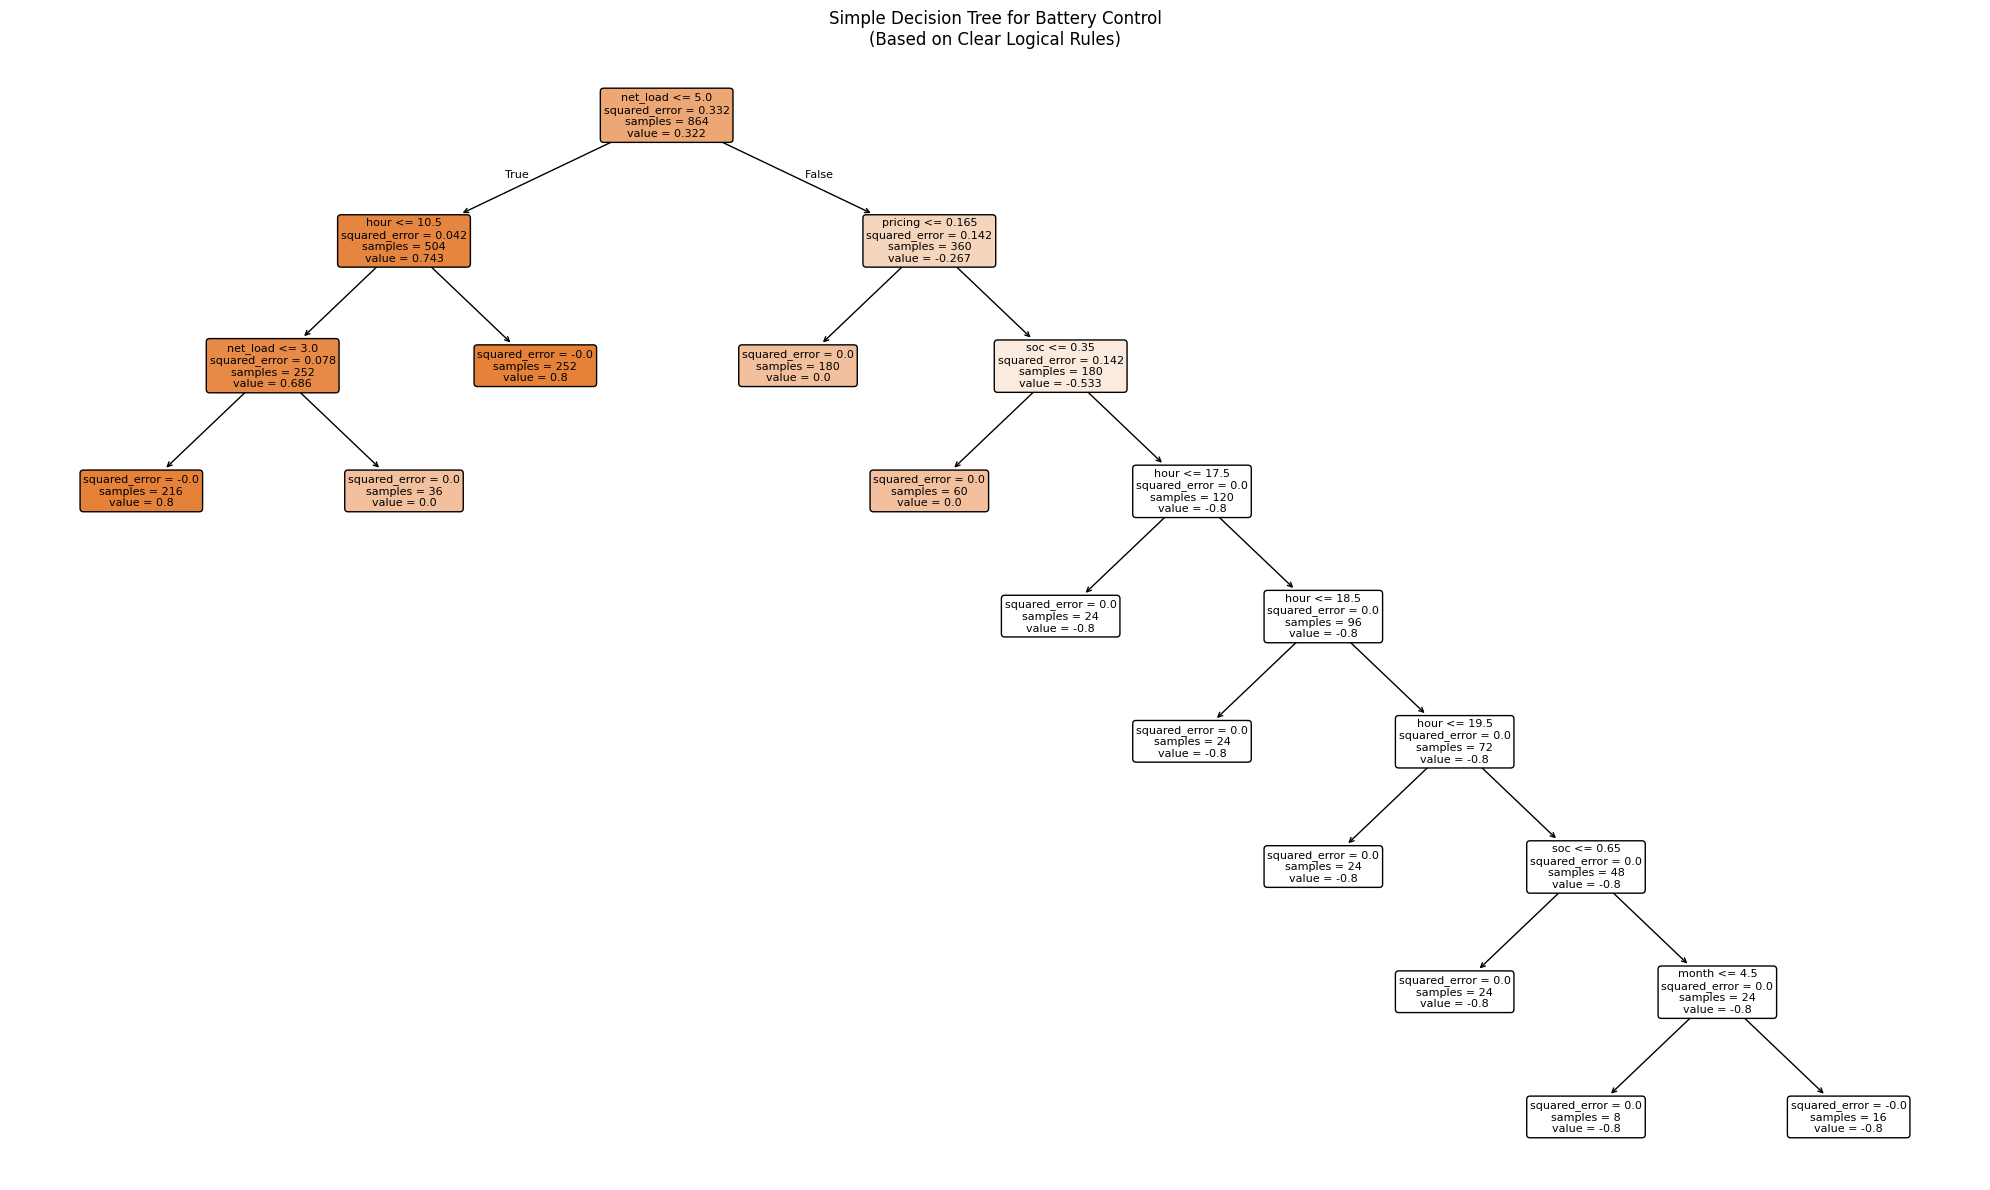

In [16]:
# ========================= TEST SIMPLE DECISION TREE =========================

# Create and train the simple decision tree
print("Creating and training simple decision tree...")

# We need to create a mock environment for training data
# Let's use the existing env but we'll create synthetic training data
simple_dt_agent = SimpleDecisionTreeRBC(env)

# Collect and train
simple_dt_agent.collect_simple_training_data()
print("\n" + "="*60)
simple_dt_agent.train_simple_decision_tree(max_depth=8)
print("\n" + "="*60)
simple_dt_agent.test_scenarios()

# Visualize the tree if it's not too complex
if simple_dt_agent.decision_tree.get_n_leaves() < 30:
    print(f"\nVisualizing decision tree...")
    plt.figure(figsize=(20, 12))
    plot_tree(simple_dt_agent.decision_tree, 
              feature_names=['hour', 'day_type', 'month', 'soc', 'pricing', 'net_load', 'solar_gen'],
              filled=True, rounded=True, fontsize=8)
    plt.title("Simple Decision Tree for Battery Control\n(Based on Clear Logical Rules)")
    plt.tight_layout()
    plt.show()
else:
    print(f"Tree too complex to visualize ({simple_dt_agent.decision_tree.get_n_leaves()} leaves)")

In [14]:
# ========================= REAL DATA DECISION TREE =========================

class RealDataDecisionTreeRBC:
    """
    Decision Tree RBC that uses real environment data with logical decision rules.
    Features: hour, day_type, month, SOC, pricing, net_load, solar_generation
    """
    
    def __init__(self, env):
        self.env = env
        self.decision_tree = None
        self.training_data = {'features': [], 'actions': []}
        
        # Action values
        self.actions = {
            'charge': 0.8,
            'discharge': -0.8, 
            'idle': 0.0
        }
        
    def collect_real_data_training(self, num_steps=500):
        """Collect training data from real environment data with logical decision rules."""
        print("Collecting training data from real environment...")
        
        # Reset environment to start from beginning
        obs, _ = self.env.reset()
        
        step_count = 0
        while step_count < num_steps:
            building = self.env.buildings[0]
            
            # Extract real features from environment
            hour = self.env.time_step % 24
            day_of_year = self.env.time_step % 8760 // 24
            month = (day_of_year // 30) % 12 + 1
            
            # Determine day type (simplified: weekend if it's every 7th day)
            day_type = 1 if (day_of_year % 7) >= 5 else 0  # 0=weekday, 1=weekend
            
            # Get real SOC
            if len(building.electrical_storage.soc) > 0:
                soc = building.electrical_storage.soc[-1]
            else:
                soc = 0.5
            
            # Get real pricing from environment
            if self.env.time_step < len(building.pricing.electricity_pricing):
                pricing = building.pricing.electricity_pricing[self.env.time_step]
            else:
                pricing = 0.15  # Default
            
            # Get real net load (non-shiftable load)
            if self.env.time_step < len(building.energy_simulation.non_shiftable_load):
                net_load = building.energy_simulation.non_shiftable_load[self.env.time_step]
            else:
                net_load = 5.0  # Default
            
            # Get real solar generation
            if self.env.time_step < len(building.energy_simulation.solar_generation):
                solar_gen = abs(building.energy_simulation.solar_generation[self.env.time_step])
            else:
                solar_gen = 0.0  # Default
            
            # Apply logical decision rules to real data
            optimal_action = self._determine_optimal_action_real_data(
                hour, day_type, month, soc, pricing, net_load, solar_gen
            )
            
            # Store training sample with real features
            features = [hour, day_type, month, soc, pricing, net_load, solar_gen]
            self.training_data['features'].append(features)
            self.training_data['actions'].append(optimal_action)
            
            # Take idle action to continue environment (for data collection only)
            action = [[0.0, 0.0, 0.0]]  # All systems idle
            obs, reward, done, truncated, info = self.env.step(action)
            
            step_count += 1
            
            if done:
                obs, _ = self.env.reset()
        
        print(f"Collected {len(self.training_data['features'])} real data training samples")
        
        # Show sample of real data with decisions
        print("\nSample of real data with logical decisions:")
        print("Hour | DayT | Month | SOC  | Price | NetLoad | Solar | Action")
        print("-" * 70)
        
        for i in range(min(15, len(self.training_data['features']))):
            features = self.training_data['features'][i]
            action = self.training_data['actions'][i]
            h, dt, m, soc, price, nl, sol = features
            action_name = self._action_to_name(action)
            print(f"{h:4.0f} | {dt:4.0f} | {m:5.0f} | {soc:4.2f} | ${price:5.3f} | {nl:7.2f} | {sol:5.2f} | {action:6.2f} ({action_name})")
        
        # Show action distribution
        actions_array = np.array(self.training_data['actions'])
        charge_count = np.sum(actions_array > 0.1)
        discharge_count = np.sum(actions_array < -0.1)
        idle_count = np.sum(np.abs(actions_array) <= 0.1)
        
        print(f"\nAction distribution on real data:")
        print(f"Charge: {charge_count} ({100*charge_count/len(actions_array):.1f}%)")
        print(f"Discharge: {discharge_count} ({100*discharge_count/len(actions_array):.1f}%)")
        print(f"Idle: {idle_count} ({100*idle_count/len(actions_array):.1f}%)")
        
        # Show some statistics about the real data
        features_array = np.array(self.training_data['features'])
        print(f"\nReal data statistics:")
        print(f"Price range: ${features_array[:, 4].min():.3f} - ${features_array[:, 4].max():.3f}")
        print(f"Net load range: {features_array[:, 5].min():.2f} - {features_array[:, 5].max():.2f} kWh")
        print(f"Solar range: {features_array[:, 6].min():.2f} - {features_array[:, 6].max():.2f} kWh")
        print(f"SOC range: {features_array[:, 3].min():.2f} - {features_array[:, 3].max():.2f}")
        
    def _determine_optimal_action_real_data(self, hour, day_type, month, soc, pricing, net_load, solar_gen):
        """Determine optimal action based on logical rules applied to real data."""
        
        # Get unique pricing values to understand high/low threshold
        # Since we know there are only 2 pricing levels, use median as threshold
        price_threshold = (unique_prices.min() + unique_prices.max()) / 2
        
        # Battery constraints
        if soc < 0.1:  # Very low SOC - must charge if possible
            if pricing <= price_threshold:  # Low price
                return self.actions['charge']
            else:
                return self.actions['idle']  # Wait for better price
                
        elif soc > 0.9:  # Very high SOC - should discharge if beneficial
            if pricing > price_threshold and net_load > solar_gen:  # High price and net grid consumption
                return self.actions['discharge']
            else:
                return self.actions['idle']
        
        # Normal SOC range (0.1 - 0.9)
        else:
            # CHARGING CONDITIONS: Low price AND good conditions
            if pricing <= price_threshold:  # Low price period
                if solar_gen > net_load:  # Excess solar - store it
                    return self.actions['charge']
                elif net_load < np.percentile(features_array[:, 5] if 'features_array' in locals() else [4], 25):  # Low net load
                    return self.actions['charge']
                else:
                    return self.actions['idle']  # Price low but conditions not ideal
            
            # DISCHARGING CONDITIONS: High price AND high demand
            elif pricing > price_threshold:  # High price period
                if net_load > solar_gen + 2 and soc > 0.3:  # High net demand and sufficient SOC
                    return self.actions['discharge']
                else:
                    return self.actions['idle']  # Save battery
            
            # NEUTRAL CONDITIONS
            else:
                return self.actions['idle']
    
    def _action_to_name(self, action):
        """Convert action value to readable name."""
        if action > 0.1:
            return "CHARGE"
        elif action < -0.1:
            return "DISCHARGE"
        else:
            return "IDLE"
    
    def train_real_data_decision_tree(self, max_depth=8):
        """Train decision tree on real data with logical decisions."""
        if len(self.training_data['features']) == 0:
            print("No training data. Collect data first...")
            self.collect_real_data_training()
        
        print("Training decision tree on real data...")
        
        X = np.array(self.training_data['features'])
        y = np.array(self.training_data['actions'])
        
        # Train decision tree
        self.decision_tree = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=15,  # Require more samples to split
            min_samples_leaf=8,    # Require more samples in leaf
            random_state=42
        )
        
        self.decision_tree.fit(X, y)
        
        print(f"Decision tree trained on real data!")
        print(f"Tree depth: {self.decision_tree.get_depth()}")
        print(f"Number of leaves: {self.decision_tree.get_n_leaves()}")
        print(f"Training samples: {len(X)}")
        
        # Show feature importance
        feature_names = ['hour', 'day_type', 'month', 'soc', 'pricing', 'net_load', 'solar_gen']
        importances = self.decision_tree.feature_importances_
        print("\nFeature Importance (from real data):")
        for name, importance in zip(feature_names, importances):
            print(f"  {name}: {importance:.3f}")
            
        return self.decision_tree
    
    def predict_action(self, hour, day_type, month, soc, pricing, net_load, solar_gen):
        """Predict action for given features."""
        if self.decision_tree is None:
            print("Decision tree not trained!")
            return 0.0
            
        features = np.array([[hour, day_type, month, soc, pricing, net_load, solar_gen]])
        action = self.decision_tree.predict(features)[0]
        return action
    
    def test_real_data_scenarios(self):
        """Test the decision tree on scenarios derived from real data patterns."""
        if self.decision_tree is None:
            print("Train the decision tree first!")
            return
            
        print("\nTesting decision tree on real data patterns:")
        print("Scenario | Hour | Price | SOC | NetLoad | Solar | Predicted | Logic")
        print("-" * 85)
        
        # Use actual data ranges for realistic test cases
        features_array = np.array(self.training_data['features'])
        low_price = unique_prices.min()
        high_price = unique_prices.max()
        avg_net_load = features_array[:, 5].mean()
        high_net_load = np.percentile(features_array[:, 5], 75)
        avg_solar = features_array[:, 6].mean()
        high_solar = np.percentile(features_array[:, 6], 75)
        
        test_cases = [
            # (hour, day_type, month, soc, pricing, net_load, solar_gen, expected_logic)
            (3, 0, 6, 0.2, low_price, avg_net_load, 0.0, "Low SOC + Low price -> CHARGE"),
            (12, 0, 6, 0.5, low_price, avg_net_load, high_solar, "Low price + High solar -> CHARGE"),
            (19, 0, 6, 0.7, high_price, high_net_load, 0.0, "High price + High load -> DISCHARGE"),
            (19, 0, 6, 0.2, high_price, high_net_load, 0.0, "High price but low SOC -> IDLE"),
            (13, 0, 6, 0.9, low_price, avg_net_load, avg_solar, "High SOC + Low price -> IDLE"),
            (20, 0, 6, 0.8, high_price, high_net_load, 0.0, "Peak conditions -> DISCHARGE"),
        ]
        
        for hour, day_type, month, soc, pricing, net_load, solar_gen, logic in test_cases:
            predicted_action = self.predict_action(hour, day_type, month, soc, pricing, net_load, solar_gen)
            predicted_name = self._action_to_name(predicted_action)
            
            print(f"Real data test | {hour:4.0f} | ${pricing:5.3f} | {soc:3.1f} | {net_load:7.1f} | {solar_gen:5.1f} | "
                  f"{predicted_name:<9} | {logic}")

print("Real Data Decision Tree RBC Agent defined!")
print("Uses actual environment data with logical decision rules")

Real Data Decision Tree RBC Agent defined!
Uses actual environment data with logical decision rules


Creating and training Real Data Decision Tree...
Collected 300 real data training samples

Sample of real data with logical decisions:
Hour | DayT | Month | SOC  | Price | NetLoad | Solar | Action
----------------------------------------------------------------------
   0 |    0 |     1 | 0.00 | $0.030 |    0.36 |  0.00 |   0.80 (CHARGE)
   1 |    0 |     1 | 0.00 | $0.030 |    0.34 |  0.00 |   0.80 (CHARGE)
   2 |    0 |     1 | 0.00 | $0.030 |    0.34 |  0.00 |   0.80 (CHARGE)
   3 |    0 |     1 | 0.00 | $0.030 |    0.33 |  0.00 |   0.80 (CHARGE)
   4 |    0 |     1 | 0.00 | $0.030 |    0.35 |  0.00 |   0.80 (CHARGE)
   5 |    0 |     1 | 0.00 | $0.030 |    0.35 |  0.00 |   0.80 (CHARGE)
   6 |    0 |     1 | 0.00 | $0.030 |    0.41 | 13.75 |   0.80 (CHARGE)
   7 |    0 |     1 | 0.00 | $0.030 |    0.40 | 104.75 |   0.80 (CHARGE)
   8 |    0 |     1 | 0.00 | $0.030 |    0.45 | 158.30 |   0.80 (CHARGE)
   9 |    0 |     1 | 0.00 | $0.030 |    0.40 | 329.17 |   0.80 (CHARGE)
  10 |   

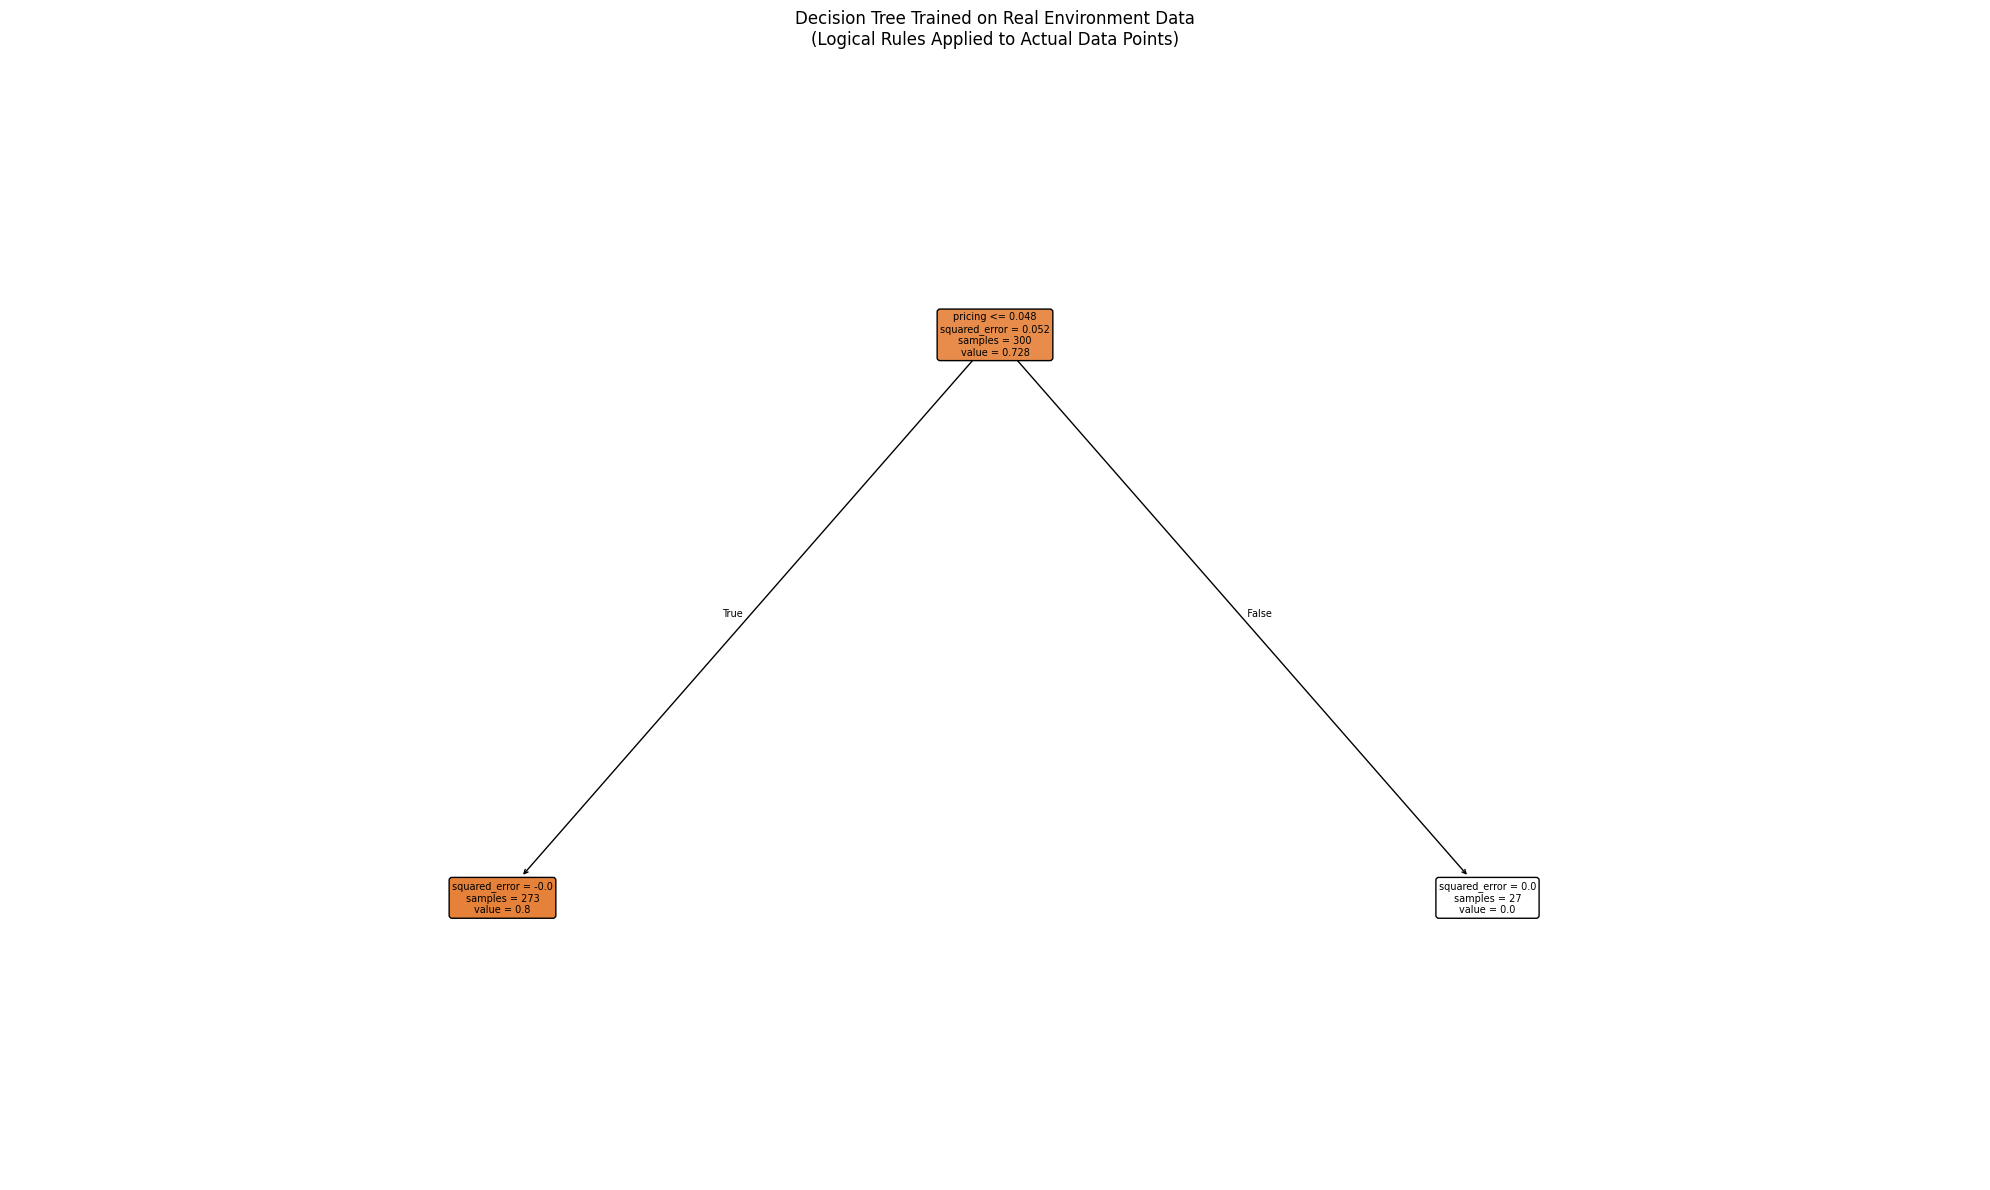


KEY ADVANTAGES OF REAL DATA APPROACH:
✅ Uses actual correlations in your dataset
✅ Respects real data ranges and distributions
✅ Learns from actual environment patterns
✅ No artificial feature combinations
✅ Decisions based on real pricing/load/solar patterns
❌ Still applies logical rules (may miss complex interactions)

NEXT STEPS for even better performance:
- Try different action evaluation methods
- Use actual cost calculation from environment
- Experiment with different decision thresholds
- Validate on longer time series


In [ ]:
# ========================= TEST REAL DATA DECISION TREE =========================

print("Creating and training Real Data Decision Tree...")

# Create the real data agent
real_dt_agent = RealDataDecisionTreeRBC(env)

# Collect training data from real environment
real_dt_agent.collect_real_data_training(num_steps=300)

print("\n" + "="*60)

# Train the decision tree
real_dt_agent.train_real_data_decision_tree(max_depth=6)

print("\n" + "="*60)

# Test scenarios
real_dt_agent.test_real_data_scenarios()

# Compare with synthetic approach
print("\n" + "="*60)
print("COMPARISON: Real Data vs Synthetic Data Approach")
print("="*60)

print(f"\nReal Data Decision Tree:")
print(f"- Uses actual environment data (hour, pricing, net_load, solar, SOC)")
print(f"- Applies logical rules to real scenarios")
print(f"- Tree depth: {real_dt_agent.decision_tree.get_depth()}")
print(f"- Number of leaves: {real_dt_agent.decision_tree.get_n_leaves()}")

print(f"\nSynthetic Data Decision Tree (previous):")
print(f"- Used artificial data combinations")
print(f"- Tree depth: {simple_dt_agent.decision_tree.get_depth()}")
print(f"- Number of leaves: {simple_dt_agent.decision_tree.get_n_leaves()}")

# Visualize the real data tree if it's not too complex
if real_dt_agent.decision_tree.get_n_leaves() < 25:
    print(f"\nVisualizing real data decision tree...")
    plt.figure(figsize=(20, 12))
    plot_tree(real_dt_agent.decision_tree, 
              feature_names=['hour', 'day_type', 'month', 'soc', 'pricing', 'net_load', 'solar_gen'],
              filled=True, rounded=True, fontsize=7)
    plt.title("Decision Tree Trained on Real Environment Data\n(Logical Rules Applied to Actual Data Points)")
    plt.tight_layout()
    plt.show()
else:
    print(f"Real data tree too complex to visualize ({real_dt_agent.decision_tree.get_n_leaves()} leaves)")


1. squared_error (or mse)
What it is: Mean Squared Error - measures how "pure" or homogeneous the node is
Range: 0.0 (perfect) to higher values (more mixed)
Meaning:
Low values (close to 0): All samples in this node have similar target values (actions)
High values: Samples in this node have very different target values
Example: If a node has squared_error = 0.0, all samples want the same action (e.g., all "charge")
2. samples
What it is: Number of training data points that reach this node
Meaning: How many of your training examples end up in this part of the tree
Example: samples = 50 means 50 training data points followed the decision path to reach this node
3. value
What it is: The average target value (action) for all samples in this node
In our case: The average battery action value
Interpretation:
Positive values (e.g., 0.8): Charge action
Negative values (e.g., -0.8): Discharge action
Near zero (e.g., 0.1): Idle action